In [ ]:
# finding single and double-positive cells

In [15]:
library(Seurat)
library(dplyr)
library(ggplot2)
library(ggpointdensity)
library(cowplot)
library(viridis)
library(ggbeeswarm)

In [3]:
# get cluster annotations from paper
cls = c(0,1,4,6,15, 12, 13,14,5,22, 21,26,29, 27,28, 31,
       9,35, 33, 8,16,17,10, 2,3,23,32,34,30, 11,24,25,36,
       7,19,20, 18)
ctypes = c(rep('A cells', 5), 'C cells', rep('B cells', 4), rep('Astrocytes', 3),
          rep('GABAergic neurons', 2), 'Neurons', rep('OPC_Oligo', 2), 'VLMC1', 
           rep('Dividing cells', 4), rep('Ependymal', 6), rep('Microglia', 4),
          rep('Endothelial', 3), 'Pericytes_VSMC')
length(unique(ctypes))

[1] 13

In [4]:
# dataset 2
sc1 = readRDS('scSeq.rds')
mtd1 = sc1@meta.data
mtd1$celltype = ctypes[match(mtd1$seurat_clusters, cls)]
mtd1[1:2,]

orig.ident    nCount_RNA nFeature_RNA nCount_Protein
AAACCCAAGTCTGGTT SeuratProject 17731      5398         21            
AAACCCAGTACACGCC SeuratProject  9791      3243         36            
                 nFeature_Protein percent.mt nCount_SCT nFeature_SCT
AAACCCAAGTCTGGTT 2                3.203429   8751       4252        
AAACCCAGTACACGCC 2                3.217240   8960       3243        
                 SCT_snn_res.0.8 SCT_snn_res.0.5 ⋯ S.Score    G2M.Score  Phase
AAACCCAAGTCTGGTT 3               3               ⋯  0.7422656  0.5886854 S    
AAACCCAGTACACGCC 14              11              ⋯ -0.1570808 -0.2067317 G1   
                 well   integrated_snn_res.0.8 integrated_snn_res.0.5
AAACCCAAGTCTGGTT well_1 3                      1                     
AAACCCAGTACACGCC well_1 16                     13                    
                 integrated_snn_res.1 integrated_snn_res.1.5
AAACCCAAGTCTGGTT 3                    16                    
AAACCCAGTACACGCC 17                   18                    
                 integrated_snn_res.2 celltype 
AAACCCAAGTCTGGTT 15                   A cells  
AAACCCAGTACACGCC 35                   OPC_Oligo

In [5]:
# cpm-normalize the raw counts
seu = CreateSeuratObject(counts = sc1@assays$RNA@counts, meta.data = mtd1)
seu <- NormalizeData(seu, normalization.method = "RC", scale.factor = 1e6)
exp1 = LayerData(seu, assay = 'RNA', layer = 'data') # cpm

Normalizing layer: counts



In [6]:
sum(exp1['Neurog2',]>0)
sum(exp1['Ascl1',]>0)
sum(exp1['Neurog1',]>0)

[1] 117

[1] 5111

[1] 11

In [8]:
# get new cell types for A1N2 and N1N2 cases
get_celltype_new <- function(exp0, g1, g2){
    gene1_exp = exp0[g1,]
    gene2_exp = exp0[g2,]
    
    vec1 = rank(gene1_exp)
    vec2 = rank(gene2_exp)
    
    vec1 <- vec1/max(vec1, na.rm = T)
    vec2 <- vec2/max(vec2, na.rm = T)

    id1 = which(vec1>0.7 & vec2>0.7) # dbl-positive
    id2 = which(vec1>0.7 & vec2<=0.7) # neurog2
    id3 = which(vec1<=0.7 & vec2>0.7) # ascl1

    ctypes = rep('none', dim(exp0)[2])
    ctypes[id1] = 'double_positive'
    ctypes[id2] = paste0(g1, '_positive')
    ctypes[id3] = paste0(g2, '_positive')

    return(ctypes)
}

In [9]:
# get cell type labels based on ranked exp bins
seu$celltype_A1N2 = get_celltype_new(exp1, 'Neurog2', 'Ascl1')
seu$celltype_N1N2 = get_celltype_new(exp1, 'Neurog2', 'Neurog1')

In [14]:
# save file
saveids = which(exp1['Neurog2',]>0 | exp1['Ascl1',]>0 | exp1['Neurog1',]>0)
length(saveids)

sce = CreateSeuratObject(counts = LayerData(seu, assay = 'RNA', layer = 'counts')[,saveids], 
                         data = exp1[,saveids], meta.data = seu@meta.data[saveids,])
sce

# save
saveRDS(sce, file = 'Cebrian_Silla_A1N1N2.rds')

[1] 5177

An object of class Seurat 
50687 features across 5177 samples within 1 assay 
Active assay: RNA (50687 features, 0 variable features)
 2 layers present: counts, data

In [11]:
gene1_exp = exp1['Neurog2',]
gene2_exp = exp1['Ascl1',]

vec1 = rank(gene1_exp)
vec2 = rank(gene2_exp)

vec1 <- vec1/max(vec1, na.rm = T)
vec2 <- vec2/max(vec2, na.rm = T)

In [9]:
cor(vec1, vec2, method = 'spearman')

[1] 0.04337345

In [16]:
dat = data.frame(m1_exp = log2(1+gene1_exp), m2_exp = log2(1+gene2_exp),
                 m1_rank = vec1, m2_rank = vec2)
dat[1:2,]

m1_exp m2_exp   m1_rank   m2_rank  
AAACCCAAGTCTGGTT 0      8.990347 0.4976093 0.9753102
AAACCCAGTACACGCC 0      0.000000 0.4976093 0.3946869

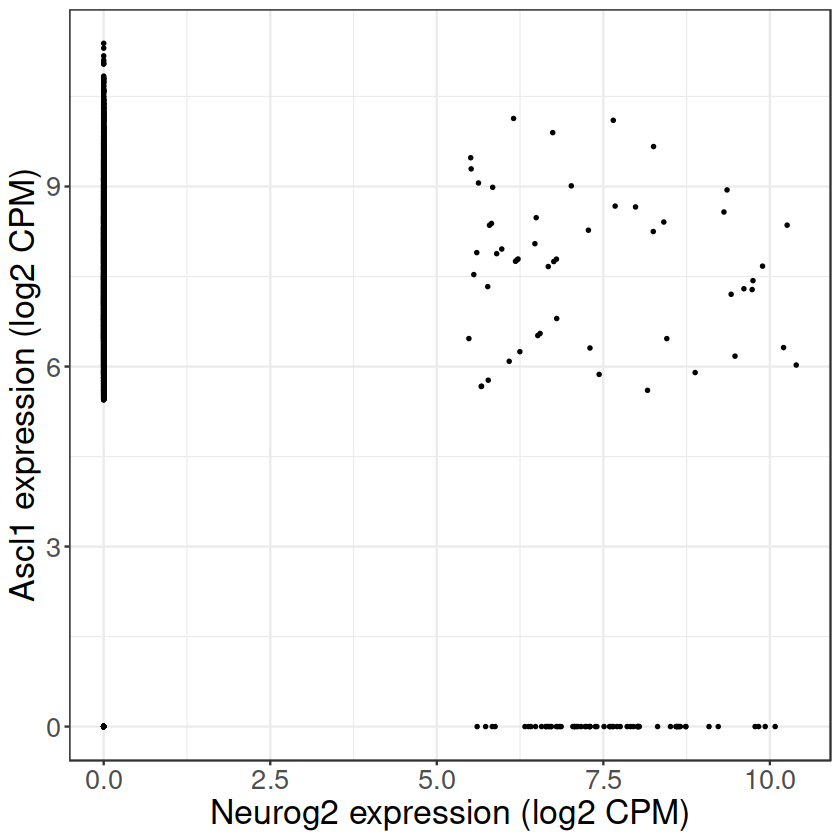

In [47]:
# png('aa-gene-exp-coexp.png', width = 5, height = 5, res = 300, units = 'in')
ggplot(dat, aes(x = m1_exp, y = m2_exp)) +
geom_point(size = 0.5) + theme_bw() + theme(text = element_text(size = 20)) +
xlab('Neurog2 expression (log2 CPM)') + ylab('Ascl1 expression (log2 CPM)')
# dev.off()

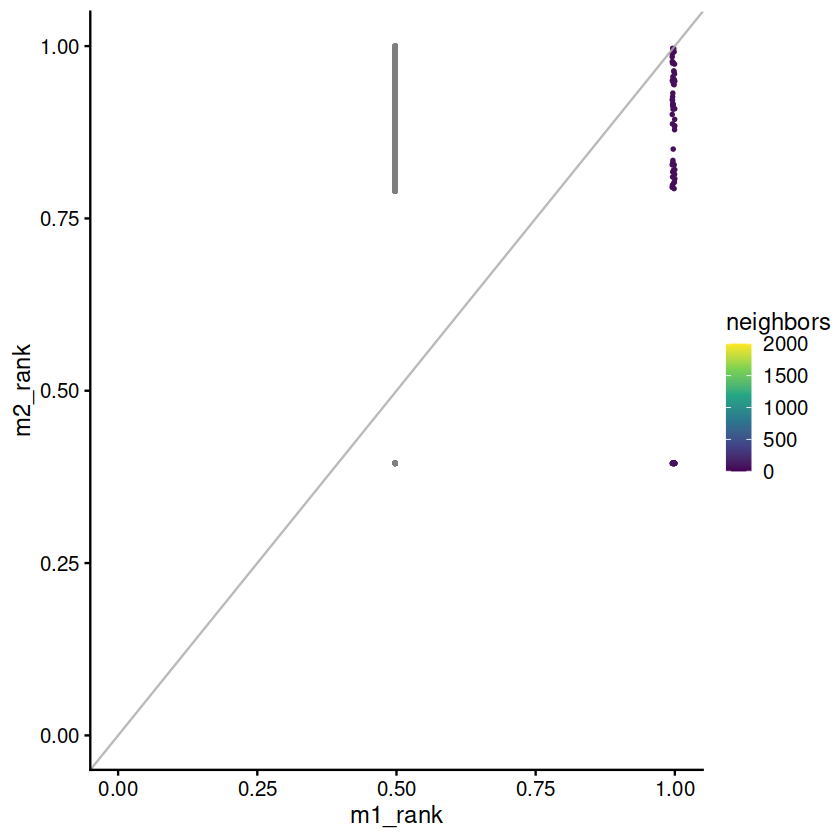

In [11]:
# png(paste0('aa-', g1, '-density-coexp.png'), width = 10, height = 5, res = 300, units = 'in')
# pdf(paste0('aa-hc-', g3, '-density-coexp.pdf'), width = 5, height = 5)

ggplot(dat, aes(x = m1_rank, y = m2_rank)) +
geom_pointdensity(size = 0.5) + scale_color_viridis_c(limits = c(0,500)) + 
geom_abline(intercept = 0, slope = 1,col = 'darkgray', lwd = 0.5, alpha = 0.8)+
theme_cowplot() + labs(col = 'neighbors') + xlim(0,1) + ylim(0,1)

# dev.off()

In [12]:
id1 = which(vec1>0.7 & vec2>0.7) # dbl-positive
id2 = which(vec1>0.7 & vec2<0.7) # neurog2
id3 = which(vec1<0.7 & vec2>0.7) # ascl1

length(id1)
length(id2)
length(id3)

[1] 54

[1] 63

[1] 5057

In [16]:
# cluster 8,10,16,22 for dbl-pos; cluster 32 for neurog2+
table(as.character(mtd1$celltype[id1]))


    Astrocytes        B cells Dividing cells      Ependymal      Microglia 
             3             10             35              5              1 

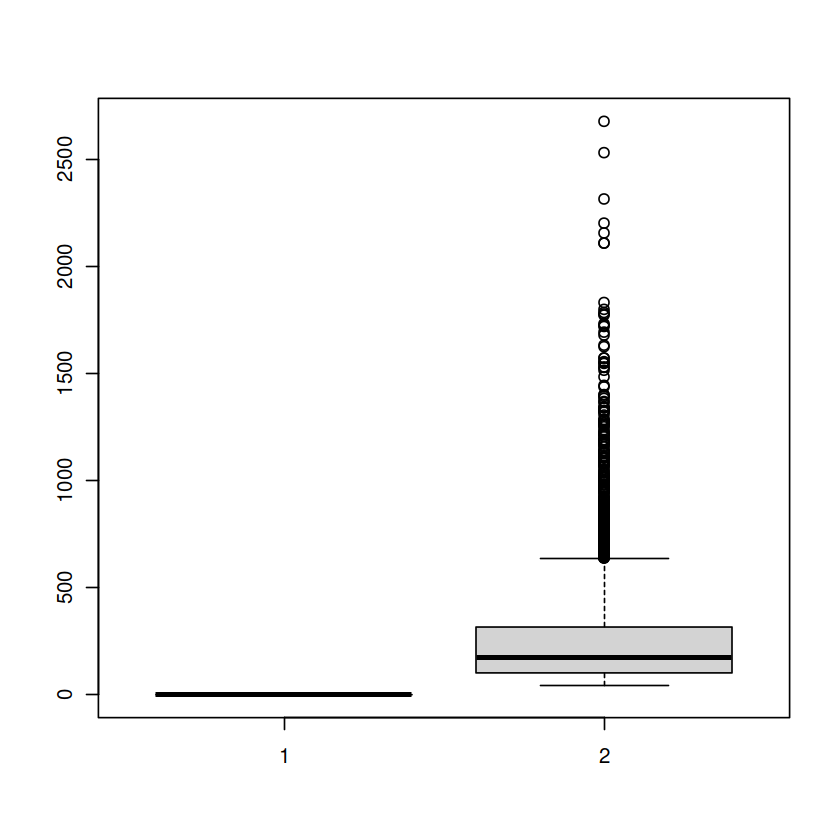

In [23]:
boxplot(exp1['Neurog2', id3], exp1['Ascl1', id3])

In [51]:
# Alex's target genes
alex = c('Bcl11a', 'Bcl11b', 'Nhlh1', 'Nhlh2', 'Sox2', 'Sox9', 'Gfap',
        'Pax6', 'Prom1', 'Foxj1', 'Rbfox3', 'Nes', 'Hopx', 'Dcx',
        'Bdnf', 'Pdgfra', 'S100b')
length(alex)

[1] 17

In [156]:
# other coexpressing genes
currgene = 'Thrsp'
sum(exp1[currgene,]>0)

# no. of cells with >0 exp in each case
sum(exp1[currgene, id1]>0)
sum(exp1[currgene, id2]>0)
sum(exp1[currgene, id3]>0)

exp_vec = exp1[currgene,]
vec3 = rank(exp_vec)
vec3 <- vec3/max(vec3, na.rm = T)
plotdf = data.frame(gene = currgene, 
                    ctype = c(rep('double+', length(id1)), rep('Neurog2+', length(id2)), rep('Ascl1+', length(id3))),
                    exp = c(log2(1+exp_vec[id1]), log2(1+exp_vec[id2]), log2(1+exp_vec[id3])),
                    rank_exp = c(vec3[id1], vec3[id2], vec3[id3]))
plotdf$ctype = factor(plotdf$ctype, levels = c('double+', 'Neurog2+', 'Ascl1+'))

[1] 4804

[1] 43

[1] 21

[1] 2236

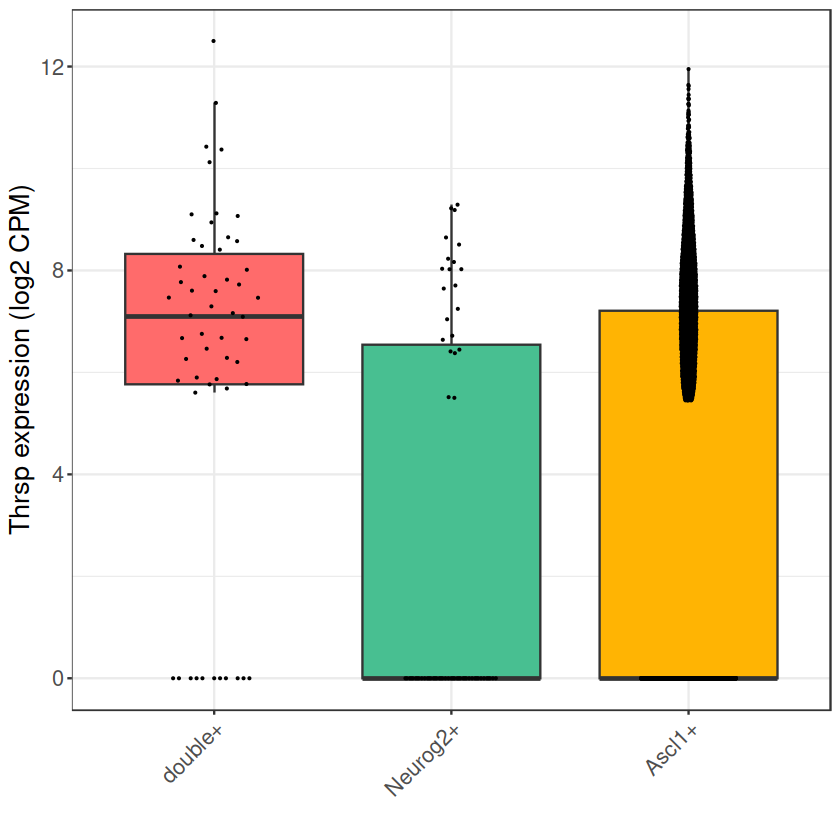

In [158]:
# png(paste0('aa-', currgene, '-exp.png'), width = 3.5, height = 5, res = 300, units = 'in')
ggplot(plotdf, aes(x = ctype, y = exp, fill = ctype)) + 
geom_boxplot(outlier.shape = NA) + geom_quasirandom(size = 0.1, width = 0.2) + theme_bw() +
theme(text = element_text(size = 16), axis.text.x = element_text(angle = 45, hjust = 1), legend.position = 'none') +
xlab('') + ylab(paste0(currgene, ' expression (log2 CPM)')) + scale_fill_manual(values = c('#ff6b6b', '#48bf91', '#ffb403'))
# dev.off()

In [10]:
# which genes show the pattern we want? (apart from Alex's targets)
# expr in double-positive > single-positive cells
options(warn = -1)
allgenes = setdiff(rownames(exp1), c('Neurog2', 'Ascl1'))
length(allgenes)

# get row ranks
r1 = matrixStats::rowRanks(as.matrix(exp1[allgenes,c(id1,id2,id3)]))
r1 <- r1/dim(exp1)[2]

pb = txtProgressBar(min = 0, max = length(allgenes), initial = 0)
gset = c()

for(ii in 1:length(allgenes)){
    vec3 = r1[ii,]

    m1 = mean(vec3[1:length(id1)])
    m2 = mean(vec3[(length(id1)+1):(length(id1)+length(id2))])
    m3 = mean(vec3[(length(id1)+length(id2)+1):(length(id1)+length(id2)+length(id3))])
    
    if(m1>m2 & m1>m3){
        gset = c(gset, allgenes[ii])
    }
    setTxtProgressBar(pb, ii)
}

length(gset)

[1] 50685

[1] 4991

In [11]:
# wow, 10% follow our trend
pb = txtProgressBar(min = 0, max = length(gset), initial = 0)

dfnew = data.frame(gene = gset, dbl_exp = 0, gene1_exp = 0, 
                   gene2_exp = 0, retain = 0)

r2 = log2(1+exp1[gset,])

for(ii in 1:length(gset)){
    vec3 = r2[ii,]

    m1 = mean(vec3[id1])
    m2 = mean(vec3[id2])
    m3 = mean(vec3[id3])    

    dfnew$dbl_exp[ii] = m1
    dfnew$gene1_exp[ii] = m2
    dfnew$gene2_exp[ii] = m3
    
    if(m1>1.5*m2 & m1>1.5*m3 & m1>2){
        dfnew$retain[ii] = 1
    }
    setTxtProgressBar(pb, ii)
}
dfnew <- dfnew %>% arrange(-retain, -dbl_exp)

sum(dfnew$retain)
dfnew[1:2,]

[1] 1604

gene  dbl_exp  gene1_exp gene2_exp retain
1 Dut   9.737628 5.920876  4.252694  1     
2 Kcnb2 9.045189 4.570119  1.020955  1

In [12]:
dfnew$gene[dfnew$retain==1]

[1] "Dut"           "Kcnb2"         "Tmpo"          "Pclaf"        
   [5] "Dtymk"         "Slbp"          "Tmem2"         "Cdk6"         
   [9] "Mms22l"        "Rrm2"          "Rbmx"          "Tipin"        
  [13] "Dtl"           "Hat1"          "Efna5"         "Dnajc9"       
  [17] "Paics"         "Mrpl28"        "Mcm7"          "Rcc2"         
  [21] "Rfc3"          "Nap1l1"        "Mcm6"          "Nsd2"         
  [25] "Srsf1"         "Dctpp1"        "Orc6"          "Hells"        
  [29] "Ppm1g"         "Dhx9"          "Lsm2"          "Baz1b"        
  [33] "Ylpm1"         "Mcm3"          "Chtop"         "Ddx1"         
  [37] "E2f1"          "Mcm5"          "Psmd6"         "Cmpk1"        
  [41] "Eif4a-ps4"     "Arl6ip6"       "Nell2"         "Cggbp1"       
  [45] "Pola1"         "Tpm3-rs7"      "Gmps"          "Mfng"         
  [49] "Mrpl3"         "Pcbp4"         "Mrps17"        "Ndufaf2"      
  [53] "Cisd2"         "Megf9"         "Rpa2"          "Tyms"         
  [57] "Tmem14c"       "Pcna"          "Atraid"        "Nars"         
  [61] "Naa20"         "Mrpl32"        "Meaf6"         "Mthfd2"       
  [65] "Sp3"           "Suz12"         "Pdcl3"         "Prim1"        
  [69] "Timm50"        "Tnpo3"         "Rcor2"         "Etfa"         
  [73] "Clspn"         "Syt4"          "Ilkap"         "Scoc"         
  [77] "Sqle"          "Gm12481"       "Kmt5a"         "Mrpl51"       
  [81] "Ogfr"          "Aifm1"         "Cdv3"          "Nsmce1"       
  [85] "Golga7"        "Mrps5"         "Dock3"         "Tgfbr1"       
  [89] "Topbp1"        "Msn"           "Rfc4"          "Tpm4"         
  [93] "Mtcl1"         "Immt"          "Coro1c"        "Gar1"         
  [97] "Casp8ap2"      "Phf23"         "2810025M15Rik" "Erp44"        
 [101] "Gipc1"         "Egfem1"        "Smc2"          "Eif3g"        
 [105] "Dyrk3"         "Bcl11a"        "Rnf165"        "Med9"         
 [109] "Stim2"         "Mrto4"         "Ogdh"          "Baz1a"        
 [113] "Dync1li1"      "Tm2d3"         "Ddx46"         "Trp53i11"     
 [117] "Ppp4c"         "Rrm1"          "Mrpl49"        "Dmrta2"       
 [121] "Snrpa1"        "Ebna1bp2"      "Cnih2"         "Sar1a"        
 [125] "Trp53"         "Eif4b"         "Fbxo3"         "Sms"          
 [129] "Cplx2"         "Rpl18"         "Hdlbp"         "Mrpl23-ps1"   
 [133] "Psmg2"         "Rnf180"        "Dcakd"         "Atp2c1"       
 [137] "Hsf2"          "Tubg1"         "Med8"          "Ybx3"         
 [141] "Mrpl27"        "Cstb"          "Mapk1ip1l"     "Hspa14"       
 [145] "Ccdc127"       "Tssc4"         "Kpnb1"         "Mrps15"       
 [149] "Fndc3a"        "Apitd1"        "Fgfr1op2"      "Ubn1"         
 [153] "Aars"          "Trappc13"      "Dlst"          "Gm9761"       
 [157] "Sf3a1"         "Cdk9"          "Mad2l2"        "Rab11a"       
 [161] "Lyar"          "Pim3"          "Gm6851"        "Rfc2"         
 [165] "Fam13b"        "Ak6"           "Psmd3"         "Uba1"         
 [169] "Mocs2"         "Rad51b"        "Enc1"          "Mrpl41"       
 [173] "Lrrc4b"        "Ndufa9"        "Zswim5"        "Gm11914"      
 [177] "Mmadhc"        "Derl1"         "Rad23b"        "Atxn2l"       
 [181] "Ddx21"         "Mkrn1"         "Mrpl21"        "Jmy"          
 [185] "Gm8494"        "Ascc3"         "Actr2"         "Limd2"        
 [189] "Aurkaip1"      "Afdn"          "Lig1"          "Vps37d"       
 [193] "Dtnbp1"        "Pcif1"         "Brd9"          "Lbr"          
 [197] "Cdc16"         "Gtf2e2"        "Gm4799"        "Polr1c"       
 [201] "Idh3b"         "Gm12396"       "Acp1"          "Nrxn2"        
 [205] "Vegfb"         "Otub1"         "Maf1"          "Agbl4"        
 [209] "Glyr1"         "Mrpl22"        "Rfc5"          "Ints10"       
 [213] "Hypk"          "Alms1"         "Chmp2a"        "Clcn3"        
 [217] "Ccdc25"        "Eif3s6-ps1"    "Nudt4"         "Spg21"        
 [221] "Ctdspl2"       "Tead2"         "Lonp2"         "Fam96a"       
 [225] "Pja2"          "Rio

In [13]:
# df for saving
write.table(dfnew, file = 'scseq_neurog2_ascl1_geneset.csv', sep = ',',
           row.names = F, col.names = T, quote = F)

In [163]:
# show avg exp and pct expressed
geneset = rev(c('Nes', 'Thrsp', 'Gpc5', 'Efhd2', 'Gpc4', 'Gli2', 'Adarb1'))
plotdf2 = c()

for(ii in 1:length(geneset)){
    currgene = geneset[ii]
    exp_vec = exp1[currgene,]
    
    temp = data.frame(gene = currgene, 
                        ctype = c('double+', 'Neurog2+', 'Ascl1+'),
                        log2_exp = c(mean(log2(1+exp_vec[id1])), mean(log2(1+exp_vec[id2])), mean(log2(1+exp_vec[id3]))),
                        pct_exp = c(sum(exp1[currgene, id1]>0)/length(id1), 
                                sum(exp1[currgene, id2]>0)/length(id2), sum(exp1[currgene, id3]>0)/length(id3)))
    plotdf2 = rbind(plotdf2, temp) 
}

plotdf2$ctype = factor(plotdf2$ctype, levels = c('double+', 'Neurog2+', 'Ascl1+'))
plotdf2$gene = factor(plotdf2$gene, levels = geneset)
plotdf2[1:3,]

gene  ctype    log2_exp pct_exp  
1 Efhd2 double+  5.281956 0.7222222
2 Efhd2 Neurog2+ 2.226157 0.3174603
3 Efhd2 Ascl1+   3.090709 0.4457188

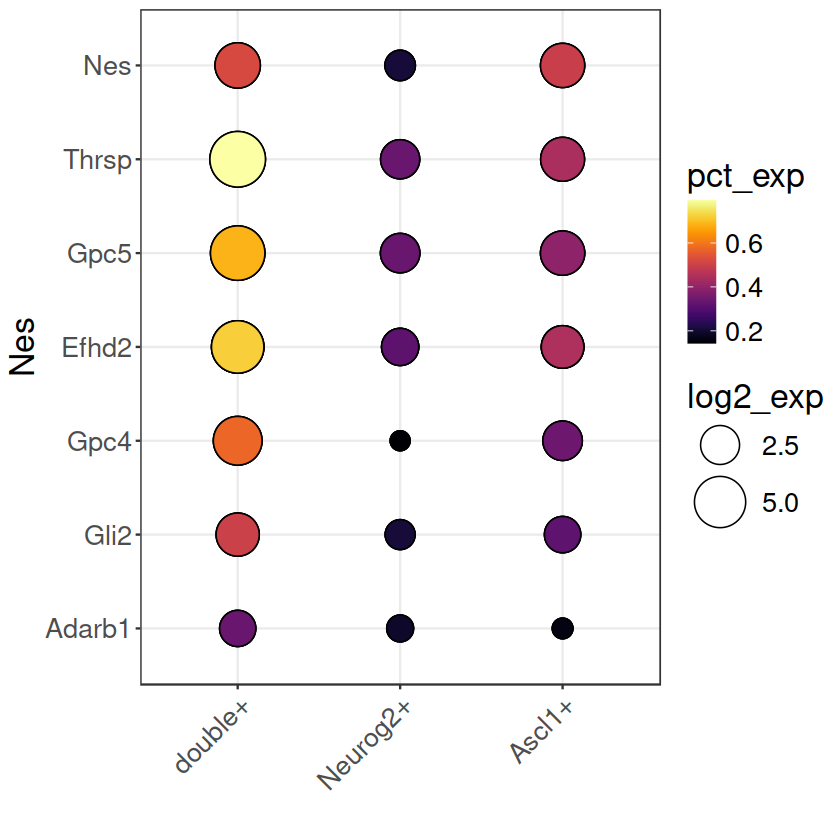

In [167]:
# png('aa-geneset-exp-pct.png', width = 5, height = 6, res = 300, units = 'in')
ggplot(plotdf2, aes(x = ctype, y = gene, label = round(pct_exp*100)/100)) +  
geom_point(shape = 21, color = 'black', aes(fill = pct_exp, size = log2_exp)) + theme_bw() + 
# geom_text(size = 6, hjust = -0.25, vjust = -2) + 
theme(text = element_text(size = 20), axis.text.x = element_text(angle = 45, hjust = 1)) +
xlab('') + ylab(currgene) + scale_fill_viridis(option = 'B') +
scale_size_continuous(breaks = c(0, 2.5, 5, 7.5, 10, 12.5, 15), range = c(5, 15)) 
# dev.off()